In [ ]:
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-aw28i6pc
  Running command git clone -q https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-aw28i6pc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-blatne93/elegantrl_133fd4bde9c94211b33c534a37f72ab3
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-blatne93/elegantrl_133fd4bde9c94211b33c534a37f72ab3
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-blatne93/pyfolio_243cc97078a14bd8817598d0b7efe2ca
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-blatne93/pyfolio_243cc97078a14bd8817598d0b7efe2ca


In [ ]:
!pip install wrds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
import plotly.express as px 
import seaborn as sns

%matplotlib inline
from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.main import check_and_make_directories
from pprint import pprint
from stable_baselines3.common.logger import configure
import sys
sys.path.append("../FinRL")

import itertools

from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

from finrl.config_tickers import DOW_30_TICKER

In [ ]:
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [ ]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [ ]:
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2018-12-31'
TEST_START_DATE = '2019-01-01'
TEST_END_DATE = '2021-12-31'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
print(df.head())

         date       open       high        low      close     volume   tic  \
0  2000-01-03   0.936384   1.004464   0.907924   0.851942  535796800  AAPL   
1  2000-01-03  70.000000  70.000000  62.875000  47.178246   22914900  AMGN   
2  2000-01-03  47.995617  47.995617  45.515598  33.552006    6471267   AXP   
3  2000-01-03  41.437500  41.687500  39.812500  25.940281    2638200    BA   
4  2000-01-03  23.843750  24.500000  23.843750  13.234138    5055000   CAT   

   day  
0    0  
1    0  
2    0  
3    0  
4    0  


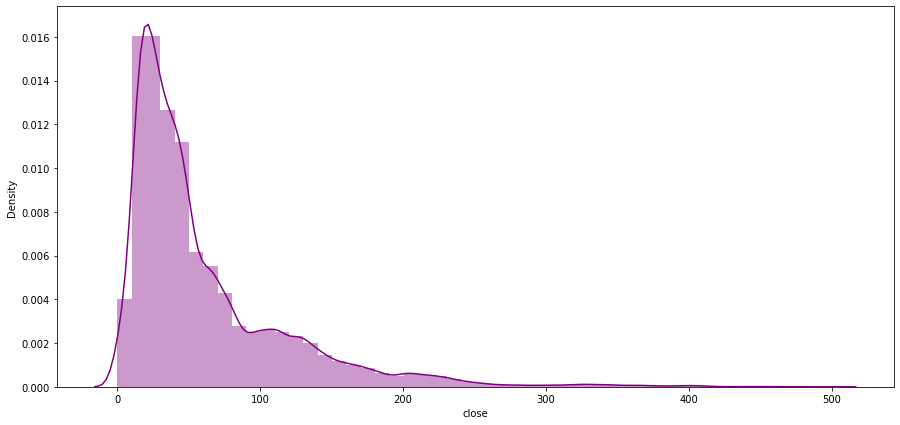

In [ ]:
plt.figure(figsize=(15,7))
sns.distplot(df['close'].dropna(), bins=50, color='purple');

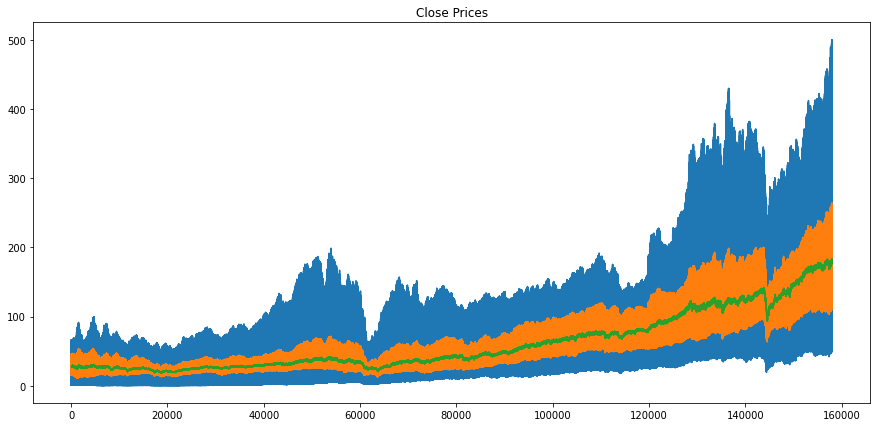

In [ ]:
sma5 = df['close'].rolling(5).mean() #5 days
sma100 = df['close'].rolling(100).mean() #100 days
 
AAPL_sma = pd.DataFrame({'AAPL': df['close'], 'SMA 5': sma5, 'SMA 100': sma100})
AAPL_sma.plot(figsize=(15, 7), legend=False, title='Close Prices');

In [ ]:
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

In [ ]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.851942,535796800,AAPL,0
1,2000-01-03,70.000000,70.000000,62.875000,47.178246,22914900,AMGN,0
2,2000-01-03,47.995617,47.995617,45.515598,33.552006,6471267,AXP,0
3,2000-01-03,41.437500,41.687500,39.812500,25.940281,2638200,BA,0
4,2000-01-03,23.843750,24.500000,23.843750,13.234138,5055000,CAT,0


In [ ]:
df_new = df.set_index("date")

df_new

,open,high,low,close,volume,tic,day
date,,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.851942,535796800,AAPL,0
2000-01-03,70.000000,70.000000,62.875000,47.178246,22914900,AMGN,0
2000-01-03,47.995617,47.995617,45.515598,33.552006,6471267,AXP,0
2000-01-03,41.437500,41.687500,39.812500,25.940281,2638200,BA,0
2000-01-03,23.843750,24.500000,23.843750,13.234138,5055000,CAT,0
...,...,...,...,...,...,...,...
2021-12-30,507.929993,509.230011,503.649994,499.586884,1309800,UNH,3
2021-12-30,217.970001,219.149994,217.149994,216.234314,3812800,V,3
2021-12-30,52.380001,52.570000,52.080002,49.538277,15615500,VZ,3


In [ ]:
AAPL = df_new[df_new['tic']== "AAPL"]

fig = px.line(AAPL,  y ="open", title='Stock Open price chart')
fig.show()

In [ ]:
AAPL = df_new[df_new['tic']== "AAPL"]

fig = px.line(AAPL,  y ="close", title='Stock Close price chart')
fig.show()

In [ ]:
AXP = df_new[df_new['tic']== "AXP"]

fig = px.line(AXP,  y ="close", title='Stock Open price chart')
fig.show()

In [ ]:
AXP = df_new[df_new['tic']== "AXP"]

fig = px.line(AXP,  y ="close", title='Stock Close price chart')
fig.show()

In [ ]:
MSFT = df_new[df_new['tic']== "MSFT"]

fig = px.line(MSFT,  y ="open", title='Stock Open price chart')
fig.show()

In [ ]:
MSFT = df_new[df_new['tic']== "MSFT"]

fig = px.line(MSFT,  y ="close", title='Stock Close price chart')
fig.show()

In [ ]:
IBM = df_new[df_new['tic']== "IBM"]

fig = px.line(IBM,  y ="open", title='Stock Open price chart')
fig.show()

In [ ]:
IBM = df_new[df_new['tic']== "IBM"]

fig = px.line(IBM,  y ="close", title='Stock Close price chart')
fig.show()

In [ ]:
reward = IBM['close'] - IBM['open']

fig = px.line(reward, title='difference in rewards')
fig.show()

In [ ]:
JPM = df_new[df_new['tic']== "JPM"]

fig = px.line(JPM,  y ="open", title='Stock Open price chart')
fig.show()

In [ ]:
JPM = df_new[df_new['tic']== "JPM"]

fig = px.line(JPM,  y ="close", title='Stock Close price chart')
fig.show()

In [ ]:
reward = JPM['close'] - JPM['open']

fig = px.line(reward, title='difference in rewards')
fig.show()

In [ ]:
url = 'D:\Users\HP\Downloads\dow_30_fundamental_wrds.csv'

available_fund = pd.read_csv(url)
print(available_fund.head())

   gvkey  datadate  fyearq  fqtr  fyr indfmt consol popsrc datafmt  tic  ...  \
0   1447  19990630    1999     2   12   INDL      C      D     STD  AXP  ...   
1   1447  19990930    1999     3   12   INDL      C      D     STD  AXP  ...   
2   1447  19991231    1999     4   12   INDL      C      D     STD  AXP  ...   
3   1447  20000331    2000     1   12   INDL      C      D     STD  AXP  ...   
4   1447  20000630    2000     2   12   INDL      C      D     STD  AXP  ...   

  dvpsxq mkvaltq     prccq     prchq     prclq  adjex ggroup    gind gsector  \
0  0.225     NaN  130.1250  142.6250  114.5000    3.0   4020  402020      40   
1  0.000     NaN  135.0000  150.6250  121.8750    3.0   4020  402020      40   
2  0.225     NaN  166.2500  168.8750  130.2500    3.0   4020  402020      40   
3  0.225     NaN  148.9375  169.5000  119.5000    3.0   4020  402020      40   
4  0.080     NaN   52.1250   57.1875   43.9375    1.0   4020  402020      40   

    gsubind  
0  40202010  
1  4020201

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (16,25) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
items = [
    'datadate', # Date
    'tic', # Ticker
    'oiadpq', # Quarterly operating income
    'revtq', # Quartely revenue
    'niq', # Quartely net income
    'atq', # Total asset
    'teqq', # Shareholder's equity
    'epspiy', # EPS(Basic) incl. Extraordinary items
    'ceqq', # Common Equity
    'cshoq', # Common Shares Outstanding
    'dvpspq', # Dividends per share
    'actq', # Current assets
    'lctq', # Current liabilities
    'cheq', # Cash & Equivalent
    'rectq', # Recievalbles
    'cogsq', # Cost of  Goods Sold
    'invtq', # Inventories
    'apq',# Account payable
    'dlttq', # Long term debt
    'dlcq', # Debt in current liabilites
    'ltq' # Liabilities   
]

# Omit items that will not be used
fund_data = available_fund[items]

In [ ]:
fund_data = fund_data.rename(columns={
    'datadate':'date', # Date
    'oiadpq':'qopincome', # Quarterly operating income
    'revtq':'quarter_rev', # Quartely revenue
    'niq':'quarter_netinc', # Quartely net income
    'atq':'totalassets', # Assets
    'teqq':'sh_equity', # Shareholder's equity
    'epspiy':'eps_incl_ex', # EPS(Basic) incl. Extraordinary items
    'ceqq':'common_equity', # Common Equity
    'cshoq':'share_outstanding', # Common Shares Outstanding
    'dvpspq':'dividend_sh', # Dividends per share
    'actq':'current_assets', # Current assets
    'lctq':'current_liabilities', # Current liabilities
    'cheq':'cash_available', # Cash & Equivalent
    'rectq':'receivables', # Receivalbles
    'cogsq':'cost_goods_sold', # Cost of  Goods Sold
    'invtq':'inventories', # Inventories
    'apq': 'payables',# Account payable
    'dlttq':'long_term_debt', # Long term debt
    'dlcq':'short_term_debt', # Debt in current liabilites
    'ltq':'total_liabilities' # Liabilities   
})

print(fund_data.head())

       date  tic  qopincome  quarter_rev  quarter_netinc  totalassets  \
0  19990630  AXP      896.0       5564.0           646.0     132452.0   
1  19990930  AXP      906.0       5584.0           648.0     132616.0   
2  19991231  AXP      845.0       6009.0           606.0     148517.0   
3  20000331  AXP      920.0       6021.0           656.0     150662.0   
4  20000630  AXP     1046.0       6370.0           740.0     148553.0   

   sh_equity  eps_incl_ex  common_equity  share_outstanding  ...  \
0     9762.0         2.73         9762.0              449.0  ...   
1     9744.0         4.18         9744.0              447.6  ...   
2    10095.0         5.54        10095.0              446.9  ...   
3    10253.0         1.48        10253.0              444.7  ...   
4    10509.0         1.05        10509.0             1333.0  ...   

   current_assets  current_liabilities  cash_available  receivables  \
0             NaN                  NaN          6096.0      46774.0   
1         

In [ ]:
date = pd.to_datetime(fund_data['date'],format='%Y%m%d')

tic = fund_data['tic'].to_frame('tic')

# Profitability ratios
# Operating Margin
operating_margin = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='operating_margin')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        operating_margin[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        operating_margin.iloc[i] = np.nan
    else:
        operating_margin.iloc[i] = np.sum(fund_data['qopincome'].iloc[i-3:i])/np.sum(fund_data['quarter_rev'].iloc[i-3:i])

# Net Profit Margin        
net_profit_margin = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='net_profit_margin')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        net_profit_margin[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        net_profit_margin.iloc[i] = np.nan
    else:
        net_profit_margin.iloc[i] = np.sum(fund_data['quarter_netinc'].iloc[i-3:i])/np.sum(fund_data['quarter_rev'].iloc[i-3:i])

# Return On Assets
return_over_assests = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='return_over_assests')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        return_over_assests[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        return_over_assests.iloc[i] = np.nan
    else:
        return_over_assests.iloc[i] = np.sum(fund_data['quarter_netinc'].iloc[i-3:i])/fund_data['totalassets'].iloc[i]

# Return on Equity
return_on_equity = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='return_on_equity')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        return_on_equity[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        return_on_equity.iloc[i] = np.nan
    else:
        return_on_equity.iloc[i] = np.sum(fund_data['quarter_netinc'].iloc[i-3:i])/fund_data['sh_equity'].iloc[i]        

# For calculating valuation ratios in the next subpart, calculate per share items in advance
# Earnings Per Share       
earnings_per_share = fund_data['eps_incl_ex'].to_frame('earnings_per_share')

# Book Per Share
book_per_share = (fund_data['common_equity']/fund_data['share_outstanding']).to_frame('book_per_share') # Need to check units

#Dividend Per Share
dividend_per_share = fund_data['dividend_sh'].to_frame('dividend_per_share')

# Liquidity ratios
# Current ratio
current_ratio = (fund_data['current_assets']/fund_data['current_liabilities']).to_frame('current_ratio')

# Quick ratio
quick_ratio = ((fund_data['cash_available'] + fund_data['receivables'] )/fund_data['current_liabilities']).to_frame('quick_ratio')

# Cash ratio
cash_ratio = (fund_data['cash_available']/fund_data['current_liabilities']).to_frame('cash_ratio')


# Efficiency ratios
# Inventory turnover ratio
inventory_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='inventory_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        inventory_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        inventory_turnover.iloc[i] = np.nan
    else:
        inventory_turnover.iloc[i] = np.sum(fund_data['cost_goods_sold'].iloc[i-3:i])/fund_data['inventories'].iloc[i]

# Receivables turnover ratio       
receivable_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='receivable_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        receivable_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        receivable_turnover.iloc[i] = np.nan
    else:
        receivable_turnover.iloc[i] = np.sum(fund_data['quarter_rev'].iloc[i-3:i])/fund_data['receivables'].iloc[i]

# Payable turnover ratio
payable_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='payable_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        payable_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        payable_turnover.iloc[i] = np.nan
    else:
        payable_turnover.iloc[i] = np.sum(fund_data['cost_goods_sold'].iloc[i-3:i])/fund_data['payables'].iloc[i]
        
## Leverage financial ratios
# Debt ratio
debt_ratio = (fund_data['total_liabilities']/fund_data['totalassets']).to_frame('debt_ratio')

# Debt to Equity ratio
debt_to_equity = (fund_data['total_liabilities']/fund_data['sh_equity']).to_frame('debt_to_equity')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning:

invalid value encountered in double_scalars



In [ ]:
ratios = pd.concat([date,tic,operating_margin,net_profit_margin,return_over_assests,return_on_equity,earnings_per_share,book_per_share,dividend_per_share,
                    current_ratio,quick_ratio,cash_ratio,inventory_turnover,receivable_turnover,payable_turnover,
                   debt_ratio,debt_to_equity], axis=1)
print(ratios.head())

        date  tic operating_margin net_profit_margin return_over_assests  \
0 1999-06-30  AXP              NaN               NaN                 NaN   
1 1999-09-30  AXP              NaN               NaN                 NaN   
2 1999-12-31  AXP              NaN               NaN                 NaN   
3 2000-03-31  AXP         0.154281          0.110742            0.012611   
4 2000-06-30  AXP         0.151641          0.108436            0.012857   

  return_on_equity  earnings_per_share  book_per_share  dividend_per_share  \
0              NaN                2.73       21.741648               0.225   
1              NaN                4.18       21.769437               0.225   
2              NaN                5.54       22.588946               0.225   
3         0.185312                1.48       23.055993               0.225   
4         0.181749                1.05        7.883721               0.080   

   current_ratio  quick_ratio  cash_ratio inventory_turnover  \
0         

In [ ]:
ratios_final = ratios.copy()
ratios_final = ratios_final.fillna(0)
ratios_final = ratios_final.replace(np.inf,0)
print(ratios_final.head())

        date  tic  operating_margin  net_profit_margin  return_over_assests  \
0 1999-06-30  AXP          0.000000           0.000000             0.000000   
1 1999-09-30  AXP          0.000000           0.000000             0.000000   
2 1999-12-31  AXP          0.000000           0.000000             0.000000   
3 2000-03-31  AXP          0.154281           0.110742             0.012611   
4 2000-06-30  AXP          0.151641           0.108436             0.012857   

   return_on_equity  earnings_per_share  book_per_share  dividend_per_share  \
0          0.000000                2.73       21.741648               0.225   
1          0.000000                4.18       21.769437               0.225   
2          0.000000                5.54       22.588946               0.225   
3          0.185312                1.48       23.055993               0.225   
4          0.181749                1.05        7.883721               0.080   

   current_ratio  quick_ratio  cash_ratio  invento

In [ ]:
list_ticker = df["tic"].unique().tolist()
list_date = list(pd.date_range(df['date'].min(),df['date'].max()))
ticker_date = list(itertools.product(list_date,list_ticker))

# Merge stock price data and ratios into one dataframe
stock_data_final = pd.DataFrame(ticker_date,columns=["date","tic"]).merge(df,on=["date","tic"],how="left")
stock_data_final = stock_data_final.merge(ratios_final,how='left',on=['date','tic'])
stock_data_final = stock_data_final.sort_values(['tic','date'])

# Backfill the ratio data to make them daily
stock_data_final = stock_data_final.bfill(axis='rows')

In [ ]:
# Calculate P/E, P/B and dividend yield using daily closing price
stock_data_final['PE'] = stock_data_final['close']/stock_data_final['earnings_per_share']
stock_data_final['PB'] = stock_data_final['close']/stock_data_final['book_per_share']
stock_data_final['Div_yield'] = stock_data_final['dividend_per_share']/stock_data_final['close']

# Drop per share items used for the above calculation
stock_data_final = stock_data_final.drop(columns=['day','earnings_per_share','book_per_share','dividend_per_share'])
# Replace NAs infinite values with zero
stock_data_final = stock_data_final.copy()
stock_data_final = stock_data_final.fillna(0)
stock_data_final = stock_data_final.replace(np.inf,0)

In [ ]:
stock_data_final.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,operating_margin,net_profit_margin,return_over_assests,...,quick_ratio,cash_ratio,inventory_turnover,receivable_turnover,payable_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2000-01-03,AAPL,0.936384,1.004464,0.907924,0.851942,535796800.0,0.070460,0.094902,0.070929,...,2.454938,1.947652,376.100000,5.571277,3.385239,0.398459,0.000000,0.331495,0.034094,0.000000
1,2000-01-03,AMGN,70.000000,70.000000,62.875000,47.178246,22914900.0,0.154281,0.110742,0.012611,...,0.000000,0.000000,46.063492,0.319717,0.550059,0.931947,13.694431,31.877193,2.046247,0.004769
2,2000-01-03,AXP,47.995617,47.995617,45.515598,33.552006,6471267.0,0.154281,0.110742,0.012611,...,0.000000,0.000000,46.063492,0.319717,0.550059,0.931947,13.694431,22.670274,1.455240,0.006706
3,2000-01-03,BA,41.437500,41.687500,39.812500,25.940281,2638200.0,0.053852,0.042201,0.050328,...,0.468367,0.196498,4.699900,11.556056,7.992536,0.675739,2.083931,54.042252,1.901102,0.005397
4,2000-01-03,CAT,23.843750,24.500000,23.843750,13.234138,5055000.0,0.106033,0.049949,0.027482,...,0.995467,0.053418,3.832268,1.929380,4.648723,0.796165,0.000000,18.128957,0.839388,0.024558
5,2000-01-03,CRM,3.750000,4.325000,3.687500,4.300000,43574400.0,0.000000,0.000000,0.000000,...,1.503176,1.050291,0.000000,0.000000,0.000000,0.225469,0.000000,11.944445,0.896538,0.000000
6,2000-01-03,CSCO,54.968750,55.125000,51.781250,38.369190,53076000.0,0.000000,0.000000,0.000000,...,1.503176,1.050291,0.000000,0.000000,0.000000,0.225469,0.000000,106.581084,7.999871,0.000000
7,2000-01-03,CVX,42.937500,42.937500,41.281250,18.007635,4387600.0,0.101839,0.066830,0.042207,...,0.641308,0.199494,13.564227,6.491652,6.410248,0.563505,0.000000,11.325557,0.651917,0.036096
8,2000-01-03,DIS,28.855125,29.533344,28.361876,23.115253,8402230.0,0.127642,0.042000,0.016826,...,0.547027,0.097219,3.012056,4.589595,2.783076,0.478972,0.934792,92.461014,2.049257,0.000000
9,2000-01-03,DOW,52.750000,53.500000,49.500000,40.797009,2350800.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,177.378298,0.000000,0.000000


In [ ]:
stock_training = data_split(stock_data_final, TRAIN_START_DATE, TRAIN_END_DATE)
stock_testing = data_split(stock_data_final, TEST_START_DATE, TEST_END_DATE)

print(len(stock_training))
print(len(stock_testing))

208110
32850


In [ ]:
print(stock_training.head())
print(stock_testing)

        date   tic       open       high        low      close       volume  \
0 2000-01-03  AAPL   0.936384   1.004464   0.907924   0.851942  535796800.0   
0 2000-01-03  AMGN  70.000000  70.000000  62.875000  47.178246   22914900.0   
0 2000-01-03   AXP  47.995617  47.995617  45.515598  33.552006    6471267.0   
0 2000-01-03    BA  41.437500  41.687500  39.812500  25.940281    2638200.0   
0 2000-01-03   CAT  23.843750  24.500000  23.843750  13.234138    5055000.0   

   operating_margin  net_profit_margin  return_over_assests  ...  quick_ratio  \
0          0.070460           0.094902             0.070929  ...     2.454938   
0          0.154281           0.110742             0.012611  ...     0.000000   
0          0.154281           0.110742             0.012611  ...     0.000000   
0          0.053852           0.042201             0.050328  ...     0.468367   
0          0.106033           0.049949             0.027482  ...     0.995467   

   cash_ratio  inventory_turnover  rec

In [ ]:
import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

matplotlib.use("Agg")



class StockTrading(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        stock_dim,
        hmax,
        initial_amount,
        buy_cost,
        sell_cost,
        rewards,
        state_space,
        action_space,
        technical_indicators,
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots=False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost = buy_cost
        self.sell_cost = sell_cost
        self.rewards = rewards
        self.state_space = state_space
        self.action_space = action_space
        self.technical_indicators = technical_indicators
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        # self.reset()
        self._seed()

    def stock_selling(self, index, action):
        def normal_selling():
            if self.state[index + 1] > 0:
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost)
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1] * sell_num_shares * self.sell_cost
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost)
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1] * sell_num_shares * self.sell_cost
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = normal_selling()
        else:
            sell_num_shares = normal_selling()

        return sell_num_shares

    def stock_buying(self, index, action):
        def normal_buying():
            if self.state[index + 1] > 0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // self.state[index + 1]
                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1] * buy_num_shares * (1 + self.buy_cost)
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += self.state[index + 1] * buy_num_shares * self.buy_cost
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = normal_buying()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = normal_buying()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig("results/account_value_trade_{}.png".format(self.episode))
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.initial_amount
            )
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252 ** 0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.close()

            return self.state, self.reward, self.terminal, {}

        else:

            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )

            argsort_actions = np.argsort(actions)

            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                actions[index] = self.stock_selling(index, actions[index]) * (-1)
            for index in buy_index:
                actions[index] = self.stock_buying(index, actions[index])

            self.actions_memory.append(actions)

            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.rewards

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        # initiate state
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [self.initial_amount]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + [0] * self.stock_dim
                    + sum(
                        [
                            self.data[tech].values.tolist()
                            for tech in self.technical_indicators
                        ],
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum([[self.data[tech]] for tech in self.technical_indicators], [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        [
                            self.data[tech].values.tolist()
                            for tech in self.technical_indicators
                        ],
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum([[self.data[tech]] for tech in self.technical_indicators], [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    [
                        self.data[tech].values.tolist()
                        for tech in self.technical_indicators
                    ],
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum([[self.data[tech]] for tech in self.technical_indicators], [])
            )
        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [ ]:
ratio_list = ['operating_margin','net_profit_margin','return_over_assests','return_on_equity','current_ratio','quick_ratio','cash_ratio','inventory_turnover','receivable_turnover','payable_turnover',
                   'debt_ratio','debt_to_equity','PE', 'PB', 'Div_yield']

stock_dim = len(stock_training.tic.unique())
state_space = 1 + 2*stock_dim + len(ratio_list)*stock_dim
print(f"Stock Dimension: {stock_dim}, State Space: {state_space}")

Stock Dimension: 30, State Space: 511


In [ ]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost": 0.001,
    "sell_cost": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dim, 
    "technical_indicators": ratio_list, 
    "action_space": stock_dim, 
    "rewards": 1e-4
    
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTrading(df = stock_training, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [ ]:
# Set up the agent using DRLAgent() class using the environment created in the previous part
agent = DRLAgent(env = env_train)

if_using_ddpg = True
if_using_ppo = False
if_using_a2c = False

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=500) if if_using_ppo else None

In [ ]:
agent = DRLAgent(env = env_train)
ddpg_model = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  ddpg_new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  ddpg_model.set_logger(ddpg_new_logger)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [ ]:
trained_ddpg_model = agent.train_model(model=ddpg_model, 
                             tb_log_name='ddpg',
                             total_timesteps=500) if if_using_ddpg else None

In [ ]:
agent = DRLAgent(env = env_train)
a2c_model = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  a2c_new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  a2c_model.set_logger(a2c_new_logger)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [ ]:
trained_a2c_model = agent.train_model(model=a2c_model, 
                             tb_log_name='a2c',
                             total_timesteps=500) if if_using_a2c else None

In [ ]:
stock_trade = data_split(stock_data_final, TEST_START_DATE, TEST_END_DATE)
e_trade_gym = StockTrading(df = stock_training, **env_kwargs)

In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.851942,535796800,AAPL,0
1,2000-01-03,70.000000,70.000000,62.875000,47.178246,22914900,AMGN,0
2,2000-01-03,47.995617,47.995617,45.515598,33.552006,6471267,AXP,0
3,2000-01-03,41.437500,41.687500,39.812500,25.940281,2638200,BA,0
4,2000-01-03,23.843750,24.500000,23.843750,13.234138,5055000,CAT,0


In [ ]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else [None, None]

df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg_model, 
    environment = e_trade_gym) if if_using_ddpg else [None, None]

df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c_model, 
    environment = e_trade_gym) if if_using_a2c else [None, None]

hit end!


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

if if_using_ppo:
  print("\n ppo:")
  perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
  perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
  perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

if if_using_ddpg:
  print("\n ddpg:")
  perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
  perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
  perf_stats_all_ddpg.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

if if_using_a2c:
  print("\n a2c:")
  perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
  perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
  perf_stats_all_a2c.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

==============Get Backtest Results===========

 ddpg:
Annual return          0.052122
Cumulative returns     3.049730
Annual volatility      0.147950
Sharpe ratio           0.417405
Calmar ratio           0.122080
Stability              0.868694
Max drawdown          -0.426946
Omega ratio            1.097666
Sortino ratio          0.597895
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.971227
Daily value at risk   -0.018395
dtype: float64


In [ ]:
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (756, 8)
Annual return          0.159544
Cumulative returns     0.559055
Annual volatility      0.235482
Sharpe ratio           0.748199
Calmar ratio           0.430198
Stability              0.680674
Max drawdown          -0.370862
Omega ratio            1.177415
Sortino ratio          1.035264
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.944436
Daily value at risk   -0.028969
dtype: float64


In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

if if_using_ppo:
  backtest_plot(df_account_value_ppo, 
              baseline_ticker = '^DJI', 
              baseline_start = TEST_START_DATE,
              baseline_end = TEST_END_DATE)

==============Compare to DJIA===========


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (756, 8)


/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1448: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1450: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1457: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1291: RuntimeWarning:

Mean of empty slice



Start date,2000-01-03
End date,2018-12-30
Total months,330
,Backtest
Annual return,5.212%
Cumulative returns,304.973%
Annual volatility,14.795%
Sharpe ratio,0.42
Calmar ratio,0.12
Stability,0.87
Max drawdown,-42.695%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,42.69,2007-12-10,2009-03-07,2010-12-02,779
1,36.69,2000-11-29,2002-07-23,2005-07-15,1208
2,15.21,2011-07-07,2011-08-10,2012-01-10,134
3,15.14,2018-12-03,2018-12-22,NaT,NaN
4,13.47,2000-01-14,2000-03-14,2000-06-02,101


/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1448: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1450: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1457: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1448: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1450: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1457: RuntimeWarning:

Mean of empty slice



Stress Events,mean,min,max
Dotcom,0.06%,-5.36%,5.99%
Lehman,-0.03%,-8.51%,5.72%
9/11,-0.01%,-4.28%,1.98%
US downgrade/European Debt Crisis,0.04%,-5.83%,4.22%
Fukushima,0.10%,-1.78%,1.36%
US Housing,-0.22%,-2.81%,2.11%
EZB IR Event,0.06%,-0.75%,1.69%
Aug07,0.07%,-2.34%,2.27%
Mar08,0.05%,-2.23%,3.28%
Sept08,-0.13%,-8.51%,5.72%


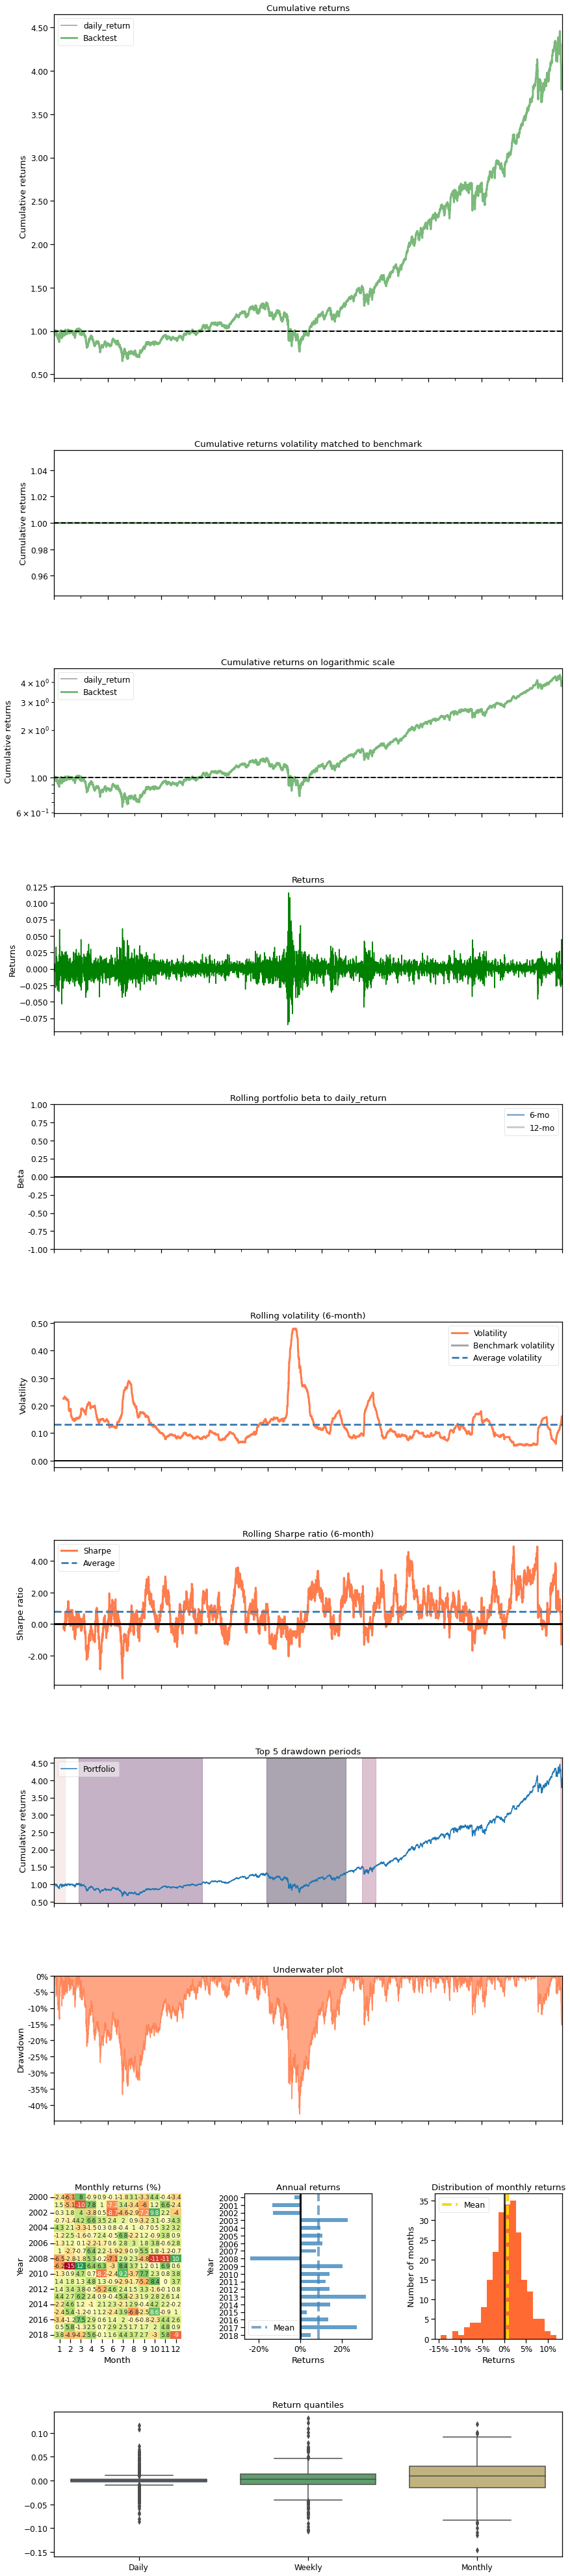

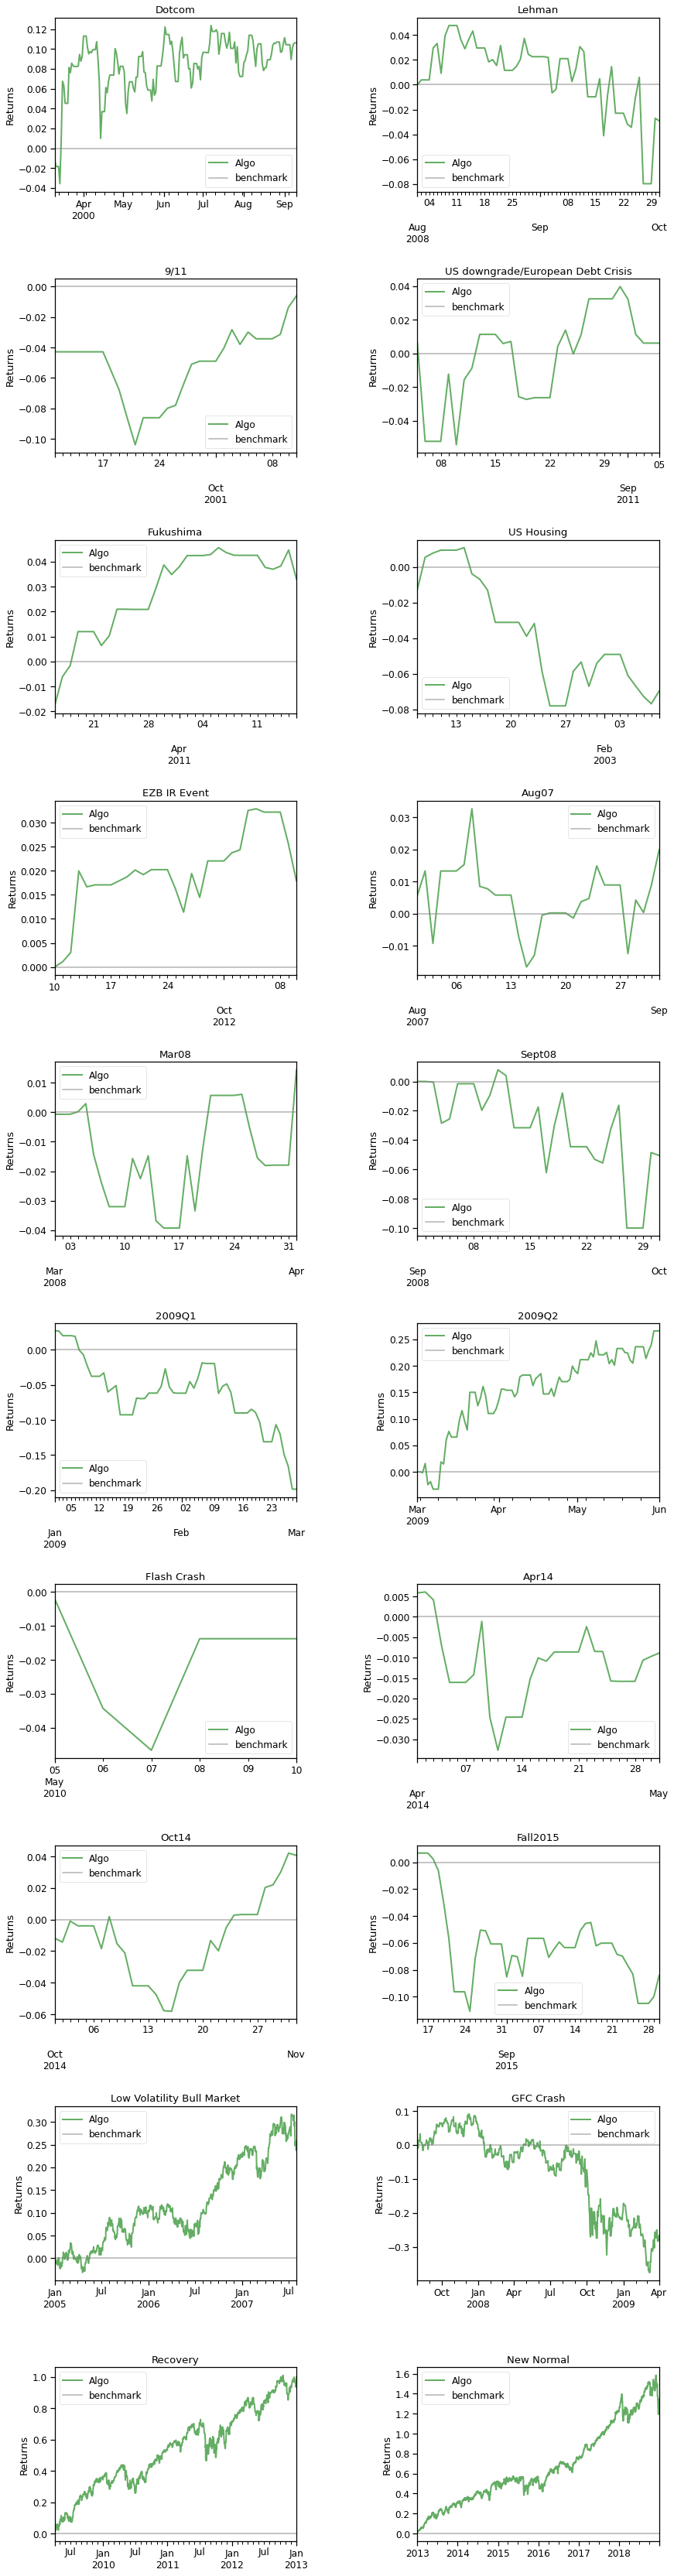

In [ ]:
if if_using_ddpg:
  backtest_plot(df_account_value_ddpg, 
              baseline_ticker = '^DJI', 
              baseline_start = TEST_START_DATE,
              baseline_end = TEST_END_DATE)

In [ ]:
if if_using_a2c:
  backtest_plot(df_account_value_a2c, 
              baseline_ticker = '^DJI', 
              baseline_start = TEST_START_DATE,
              baseline_end = TEST_END_DATE)